Setup

In [1]:
from LNL import define_save_LNL_model
from Full_model import define_model,train_and_save
from sparse_model_v2 import define_model_sparse,train_and_save_sparse
import os
import time
from image_receptive_field import visualize_img_recep
from compare_imgs import show_img_compare
from Full_model_CNN import define_model_CNN,train_and_save_CNN
from model_summary import show_generator,visualize_weights
from plot_error import show_error,comp_error
from Full_model_local_patch import define_model_local,train_and_save_local
cwd = os.getcwd()
LNL_model_path = cwd+'/data/LNL_model.pth'

Define the LNL section of the model and saves it for later use

In [2]:
# whether to use curated resolvable gaussian radius of ERF
FHWM=False
img_side_dim = 32
# if not define current spread arbitrarily here
current_spread = 1
# define the electrode grid
elec_side_dim = 8
activ_spread= 0
#define neuron grid
neu_side_dim = 16

# define the LNL layer with gaussian electrical receptive field
W_d = define_save_LNL_model(LNL_model_path,elec_side_dim, neu_side_dim, activ_spread, current_spread,FHWM)


Create a mask for localised patches, and perform localised patch ANN

In [3]:

kernal_size = 8
import numpy as np
import torch
img_side_dim = 32
elec_side_dim = 8

input_size = img_side_dim**2
output_size = elec_side_dim**2
mask_np = np.zeros((input_size, output_size))
for i in range(elec_side_dim): 
    for j in range(elec_side_dim):
        curr_elec = i*elec_side_dim + j  # zero based current electrode (first one is 0)
        rows = range(max(0, (4*i - 2)), min(img_side_dim,(4*i + 6)))
        for row in rows: 
            start = max(0,(4*j - 2))
            end =  min((4*j-2+kernal_size),img_side_dim)
            # Calculate indices
            indices = [row * img_side_dim + col for col in range(start, end)]
            mask_np[indices,curr_elec] = 1
mask_torch = torch.from_numpy(mask_np)
#mask_torch = mask_torch.t()
#print(mask_np)

Define the Full model to be trained

In [4]:
# define the full model to be trained
drop_rate = 0.2
# options for activation functions are "linear", "2sig" and "ReLU"
activ_funcs_options = ["linear", "2sig","ReLU"]
activ_func1 = activ_funcs_options[0]
activ_func2 = activ_funcs_options[1]
# shift and magnitude defines the 2sig function shape
shift = 9
magnitude = 0.5
noise = 0.1

#AutoEncoder = define_model(elec_side_dim,neu_side_dim, LNL_model_path, drop_rate, activ_func1,activ_func2,shift,magnitude,noise)
#AutoEncoder = define_model_sparse(elec_side_dim,neu_side_dim, LNL_model_path, drop_rate, activ_func1,activ_func2,shift,magnitude)
#AutoEncoder = define_model_CNN(elec_side_dim,neu_side_dim, LNL_model_path, drop_rate, activ_func1,activ_func2,shift,magnitude,noise,img_side_dim)
AutoEncoder = define_model_local(elec_side_dim,neu_side_dim, LNL_model_path, drop_rate, activ_func1,activ_func2,shift,magnitude,noise,img_side_dim, mask_torch)


In [5]:
model_title = "local_patch_test" 

Train the model and save the model for result demo
Default Model:

In [6]:
# n_epochs = 50
# mult_lr = False
# start_time = time.time()
# train_and_save(n_epochs,AutoEncoder,model_title,mult_lr)
# end_time = time.time()
# execution_time = end_time - start_time
# print(f"Execution time: {execution_time} seconds")

Default FC model with CNN as 1st layer

In [7]:
# n_epochs = 50
# mult_lr = False
# start_time = time.time()
# train_and_save_CNN(n_epochs,AutoEncoder,model_title,mult_lr)
# end_time = time.time()
# execution_time = end_time - start_time
# print(f"Execution time: {execution_time} seconds")

local patch custom layer

In [8]:
n_epochs = 50
mult_lr = False
start_time = time.time()
train_and_save_local(n_epochs,AutoEncoder,model_title,mult_lr)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Files already downloaded and verified
Files already downloaded and verified
Epoch [0/50], Loss: 0.0360
Epoch [10/50], Loss: 0.0177
Epoch [20/50], Loss: 0.0227
Epoch [30/50], Loss: 0.0173
Epoch [40/50], Loss: 0.0181
Execution time: 479.34960770606995 seconds


Sparse Model

In [9]:
# n_epochs = 200
# mult_lr = False
# start_time = time.time()
# _lambda = 0.000005
# train_and_save_sparse(n_epochs,AutoEncoder,model_title,_lambda,mult_lr = False)
# end_time = time.time()
# execution_time = end_time - start_time
# print(f"Execution time: {execution_time} seconds")

Result Demo

In [10]:
# set the file directory to show
cwd = os.getcwd()
#model_path = cwd+f'/data/240729_data/model_lr = 0.0001_lnr_10elec.pth'

model_path = cwd+f'/data/model_{model_title}_lr = 0.0001.pth'

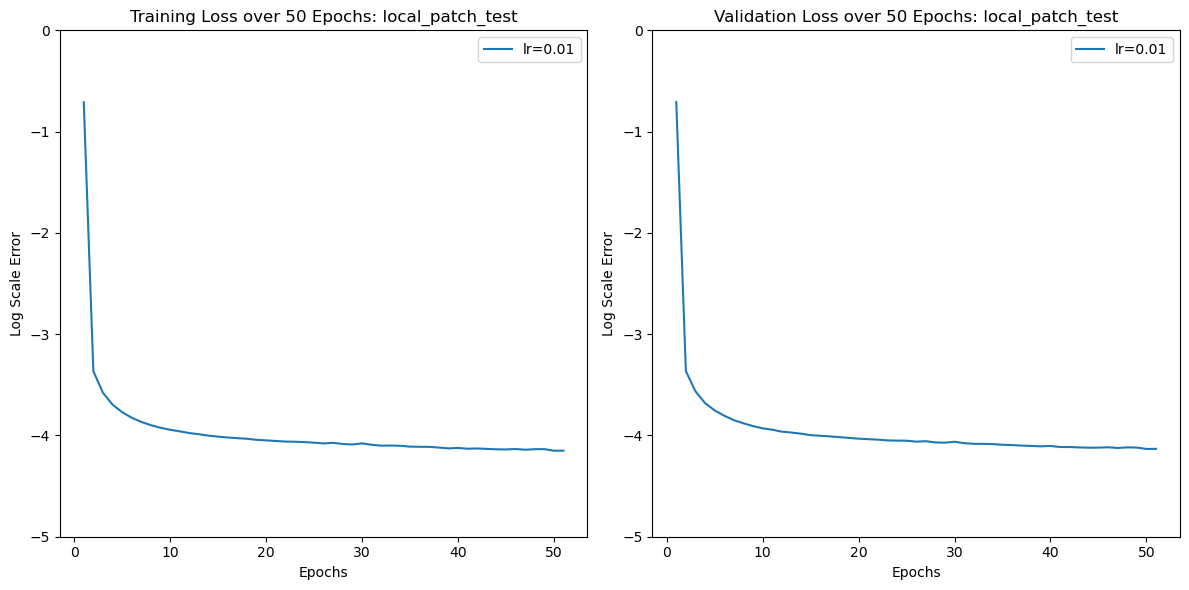

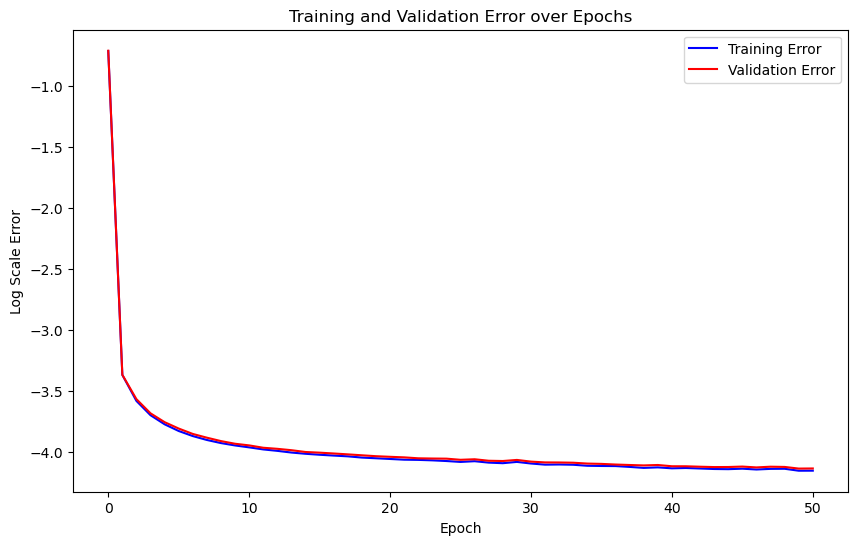

In [11]:
data_path = cwd + f'/data/NN_{model_title}_output.pkl'

show_error(data_path,model_title)
comp_error(data_path,model_title)

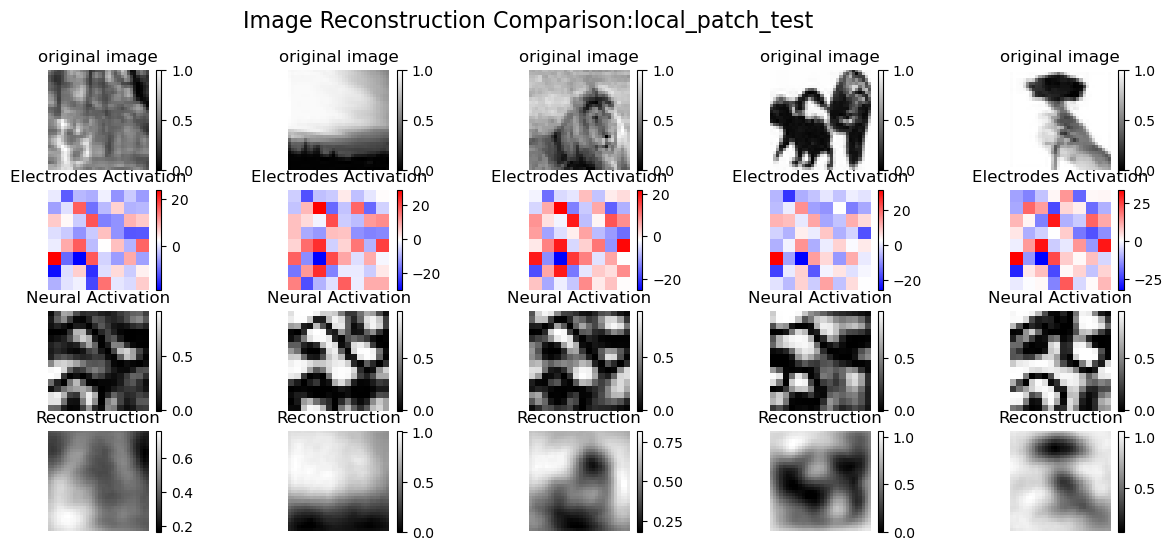

In [12]:
# import math
# import matplotlib.pyplot as plt
# import numpy as np
# import torch
output_test_flat, layer1_flat, layer2_flat = show_img_compare(model_path, AutoEncoder,model_title)
# layer1_flat = layer1_flat.detach().numpy()
# test_lyr2_flat = layer1_flat @ (W_d.transpose())


# sigmoid1 = 1/(1+np.exp(magnitude * (test_lyr2_flat + shift)))
# sigmoid2 = 1/(1+np.exp(-1*magnitude * (test_lyr2_flat - shift)))
# test_lyr2_flat = sigmoid1 + sigmoid2

# test_lyr2_flat = torch.tensor(test_lyr2_flat)



# side_dim = int(math.sqrt(test_lyr2_flat.shape[1]))
# test_lyr2 = test_lyr2_flat.view(test_lyr2_flat.shape[0],side_dim,side_dim)
# test_lyr2_np = test_lyr2.detach().numpy()

# lyr2 = layer2_flat.view(layer2_flat.shape[0],side_dim,side_dim)
# lyr2_np = lyr2.detach().numpy()

# # Create a figure with 2 subplots side by side
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# # Plotting on the first subplot
# img1 = ax1.imshow(test_lyr2_np[4],cmap='gray')

# # Plotting on the second subplot
# img2 = ax2.imshow(lyr2_np[4],cmap='gray')
# fig.colorbar(img1, ax=ax1, fraction=0.046, pad=0.04) 
# fig.colorbar(img2, ax=ax2, fraction=0.046, pad=0.04) 
# # Adjust the space between the plots
# plt.tight_layout()

# # Display the plots
# plt.show()

AttributeError: 'CustomLayer' object has no attribute 'weight'

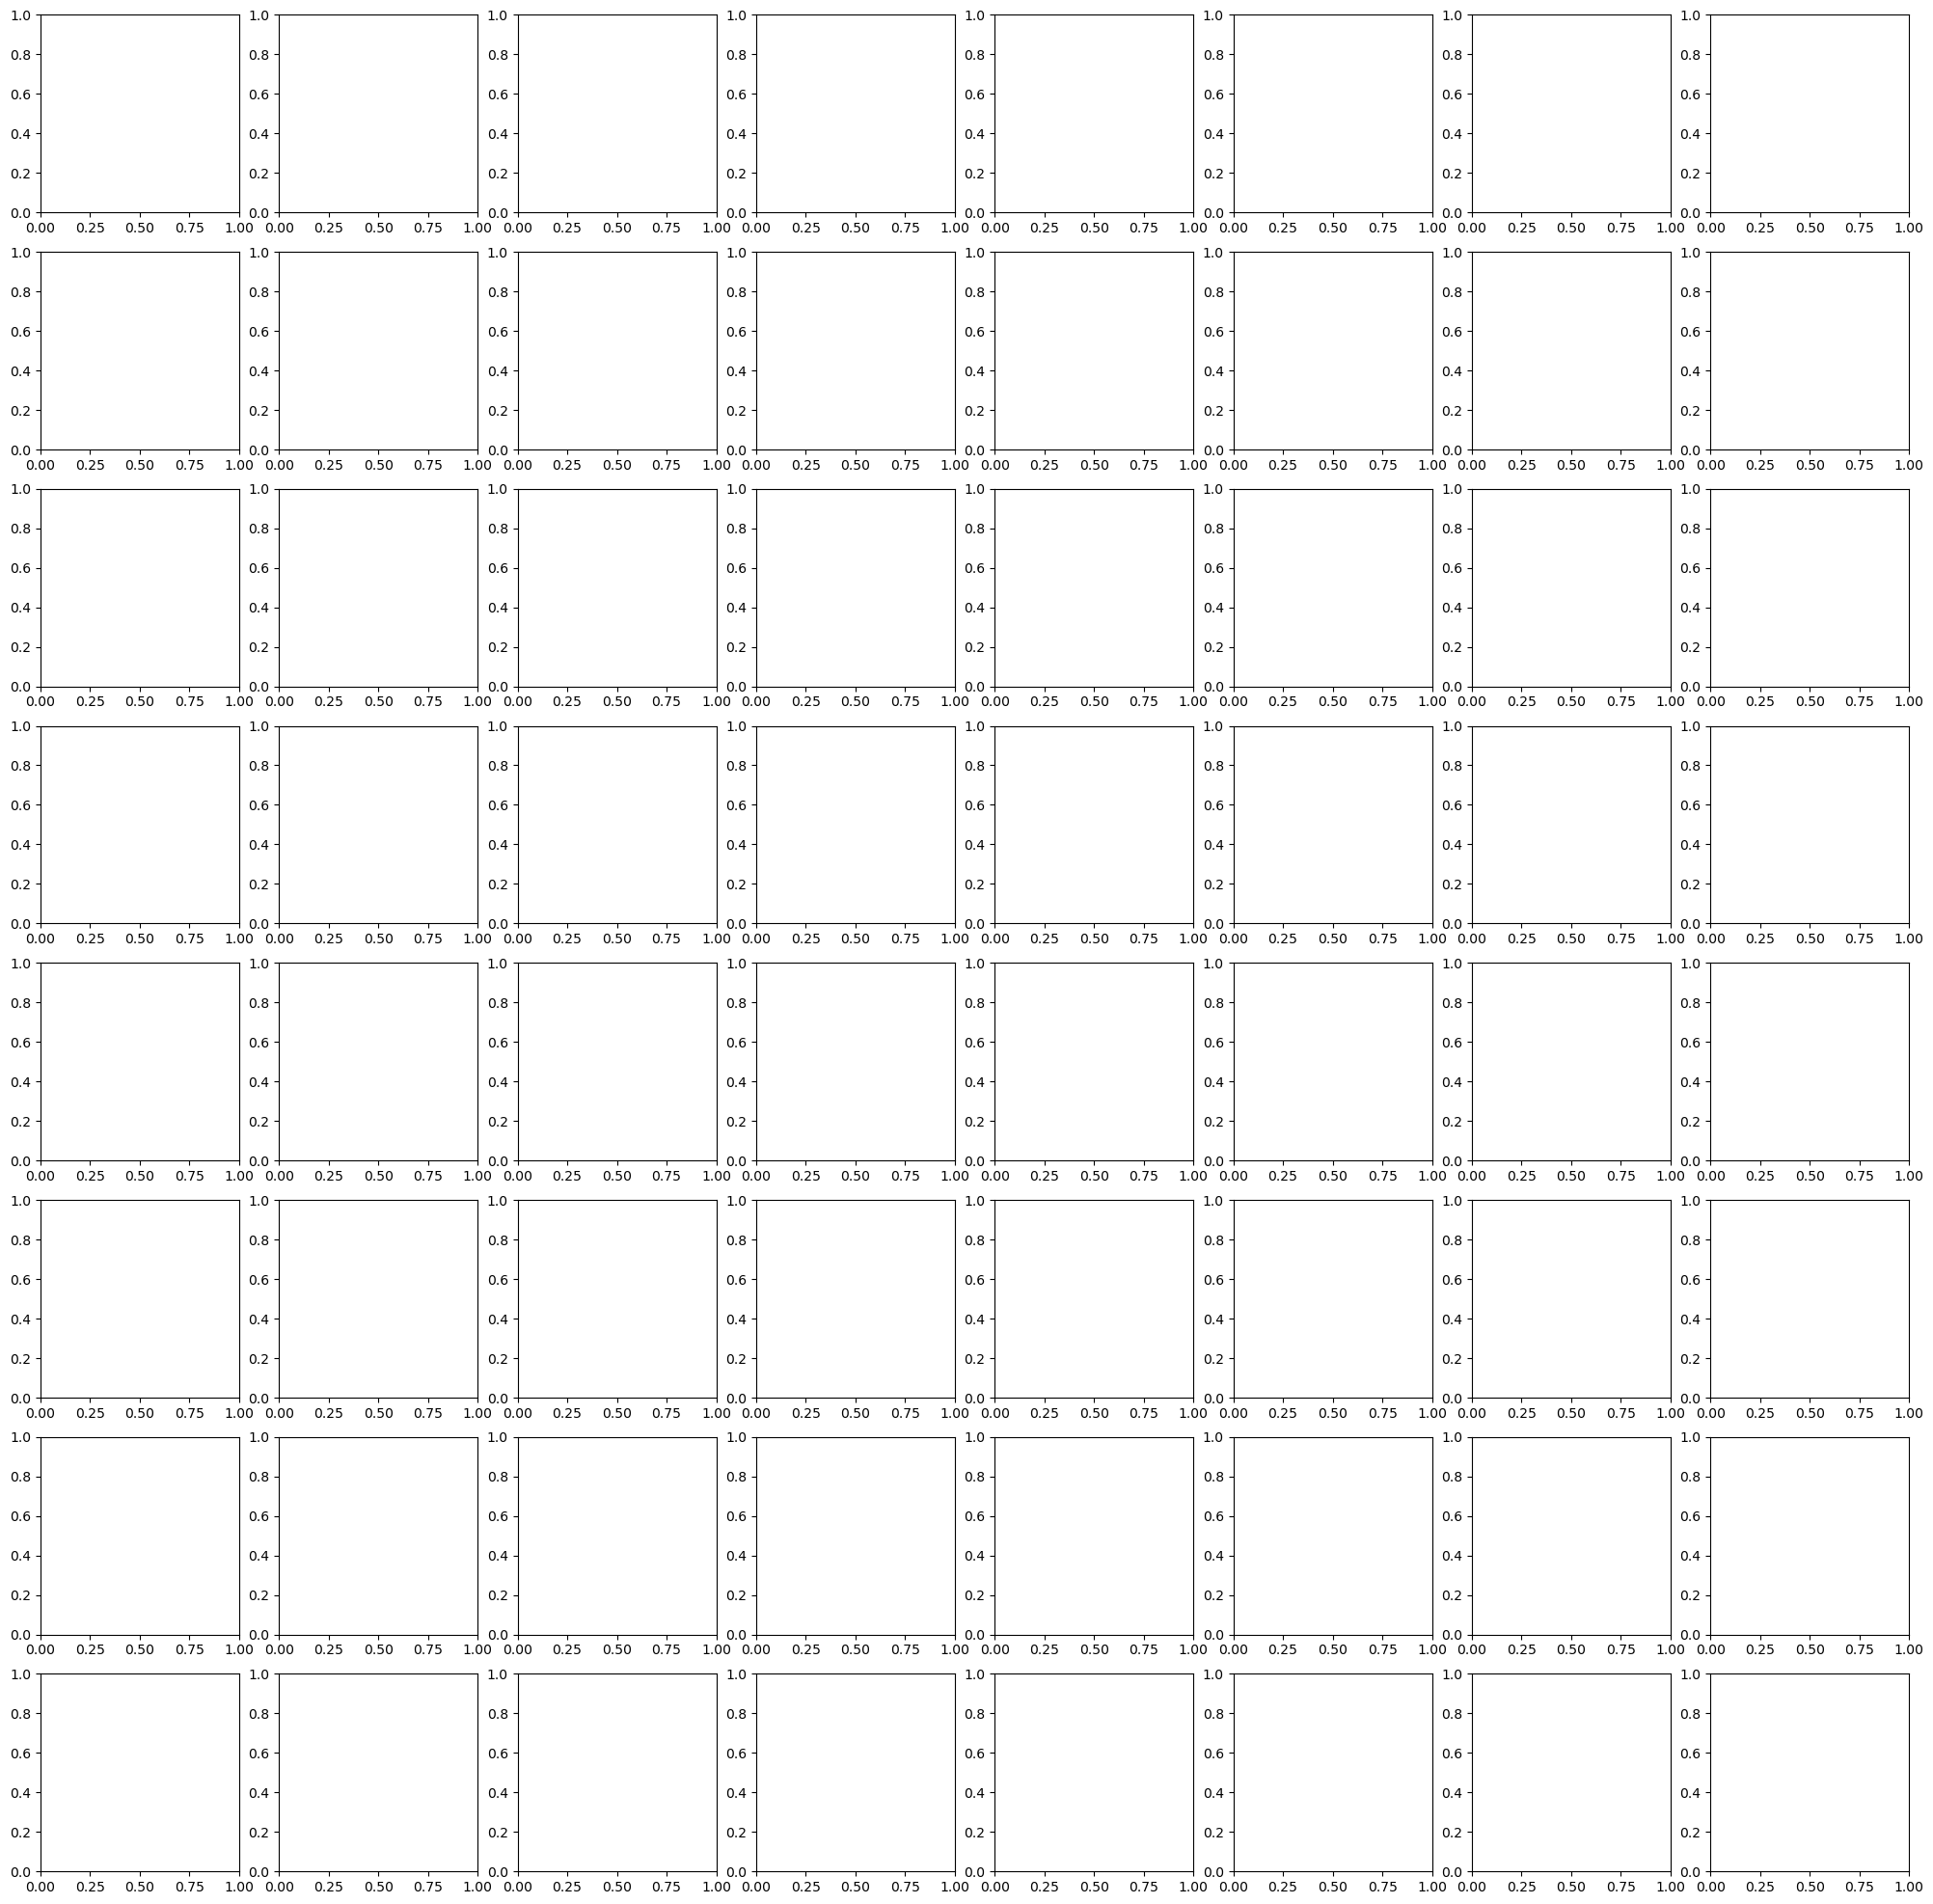

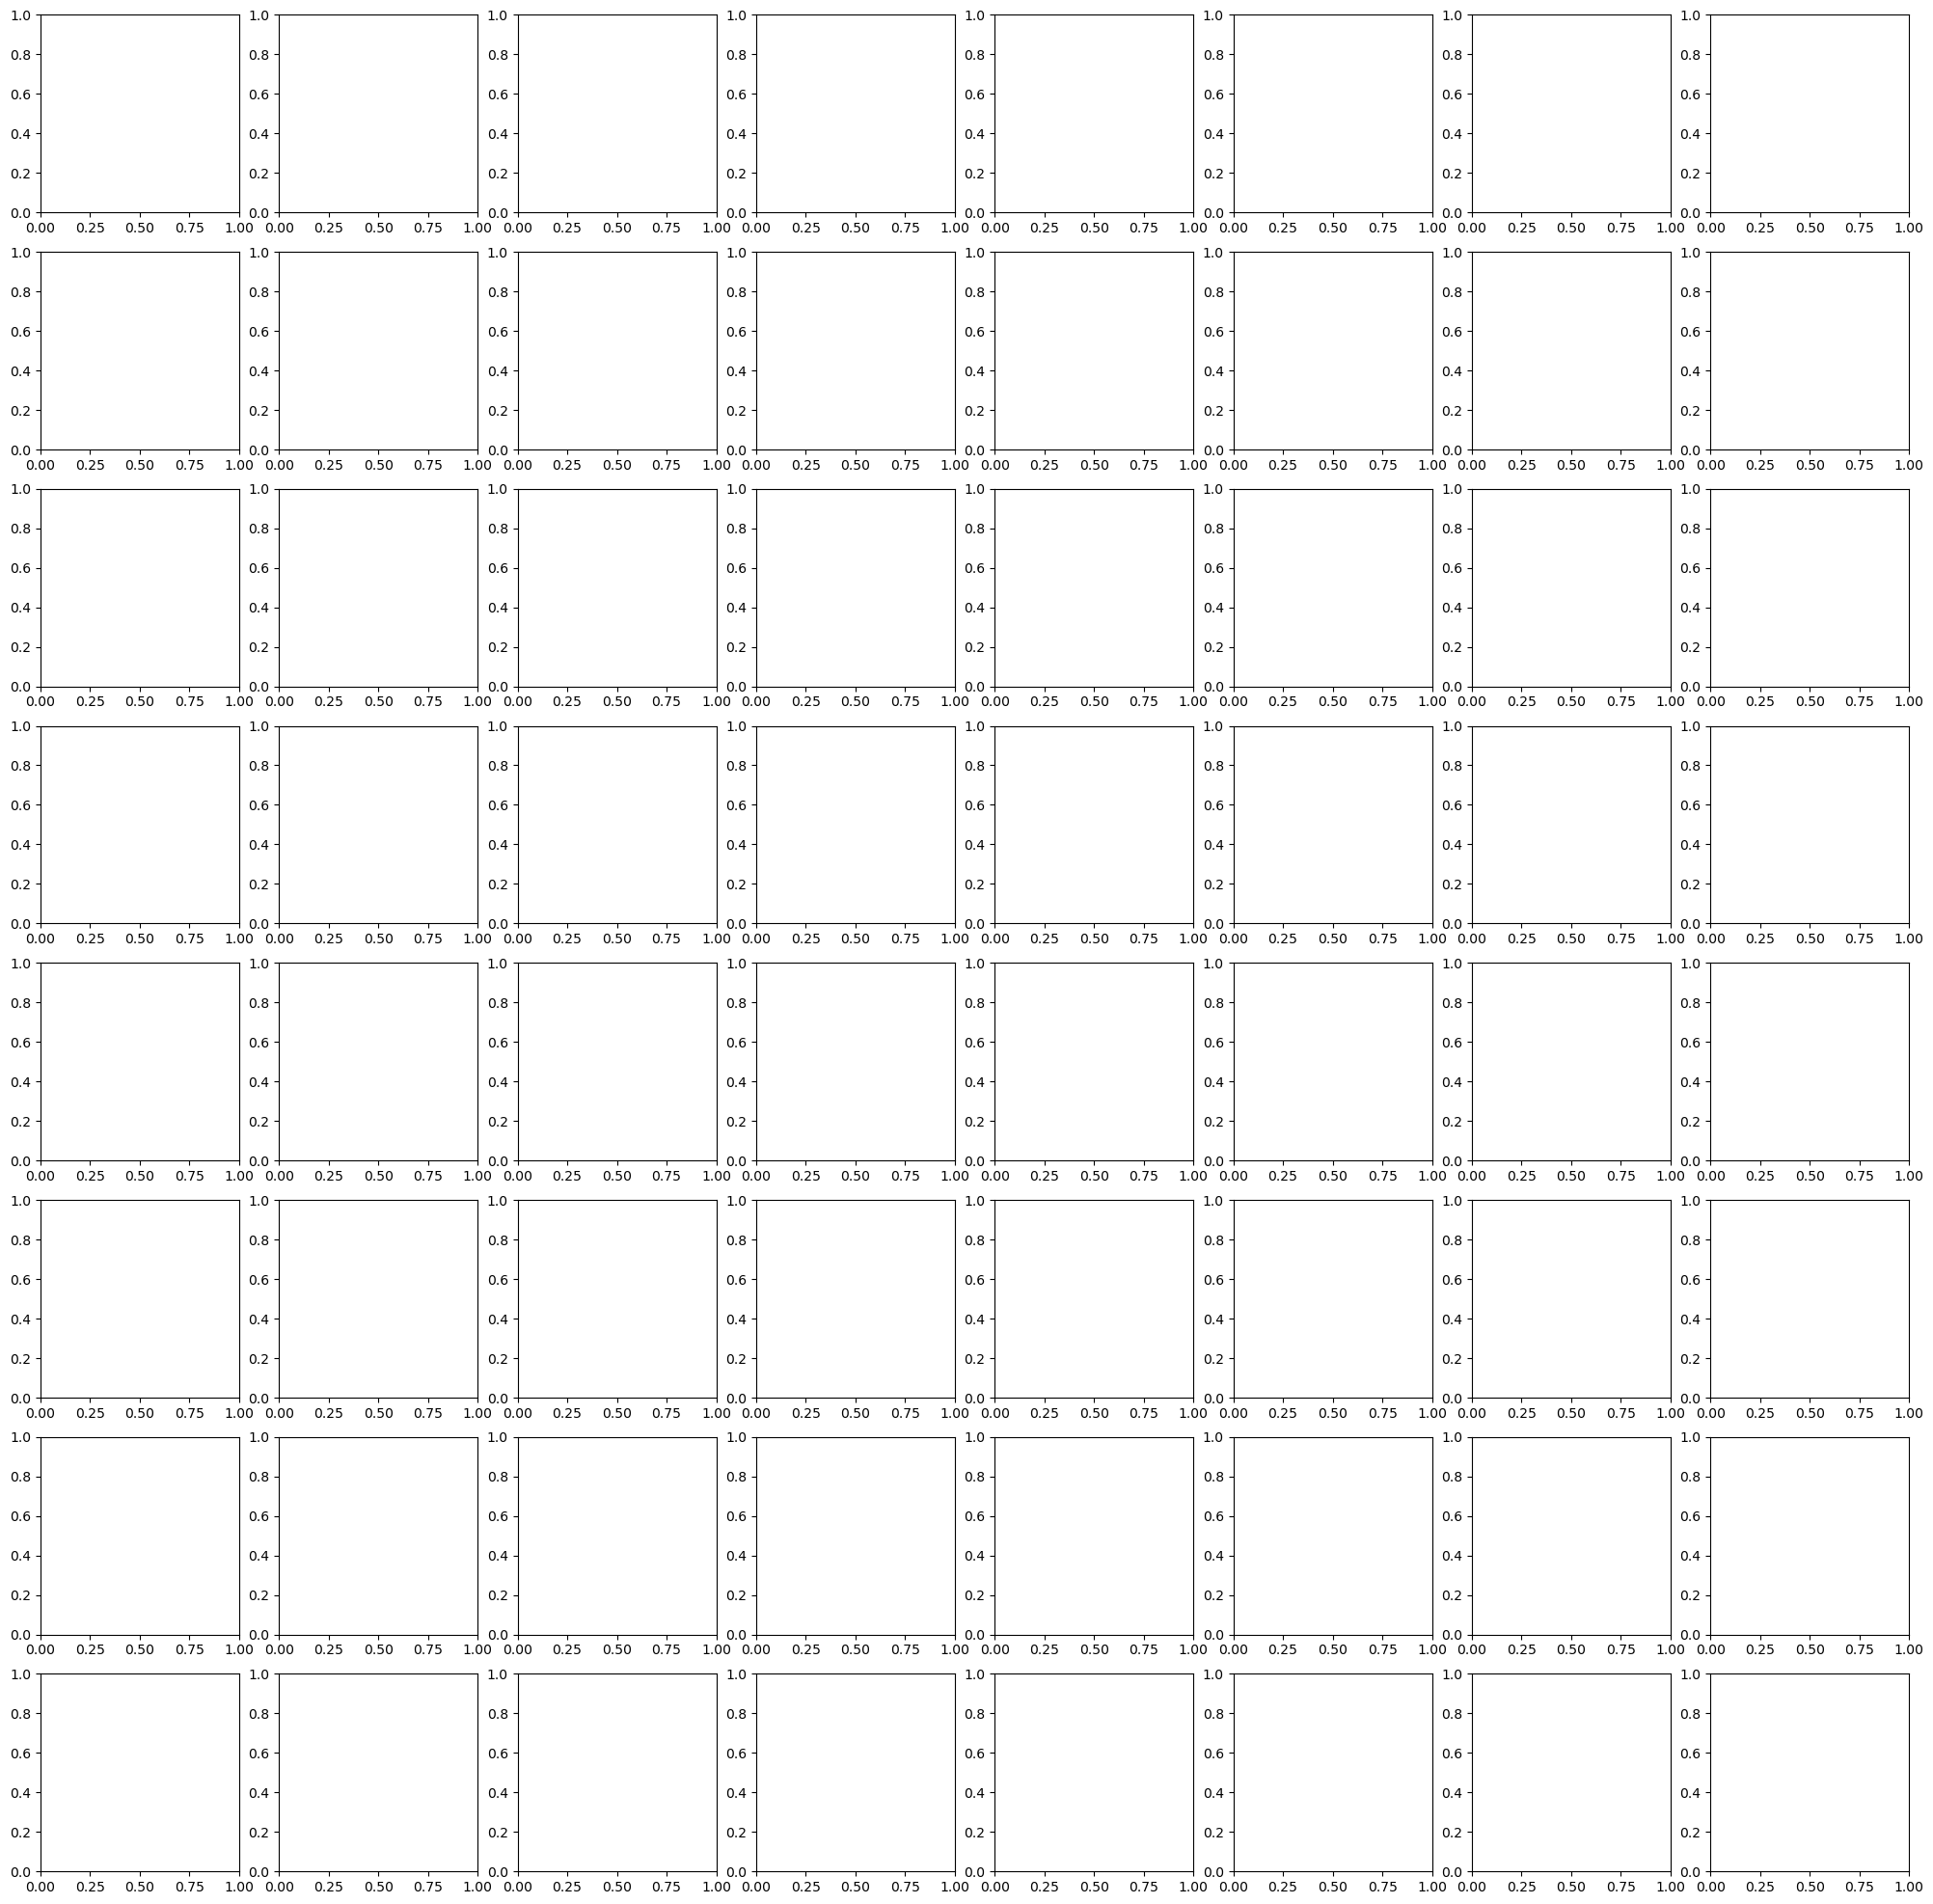

In [13]:
img_side_dim = 32
show_FFT = True
recep_mem = visualize_img_recep(model_path, AutoEncoder, img_side_dim,elec_side_dim,model_title,show_FFT)

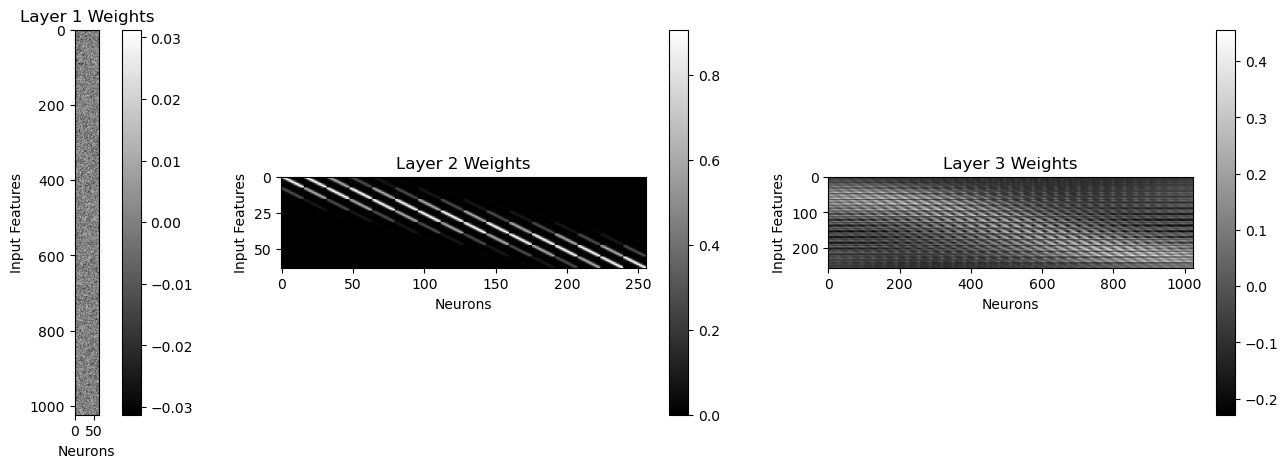

In [ ]:
visualize_weights(AutoEncoder,model_path)

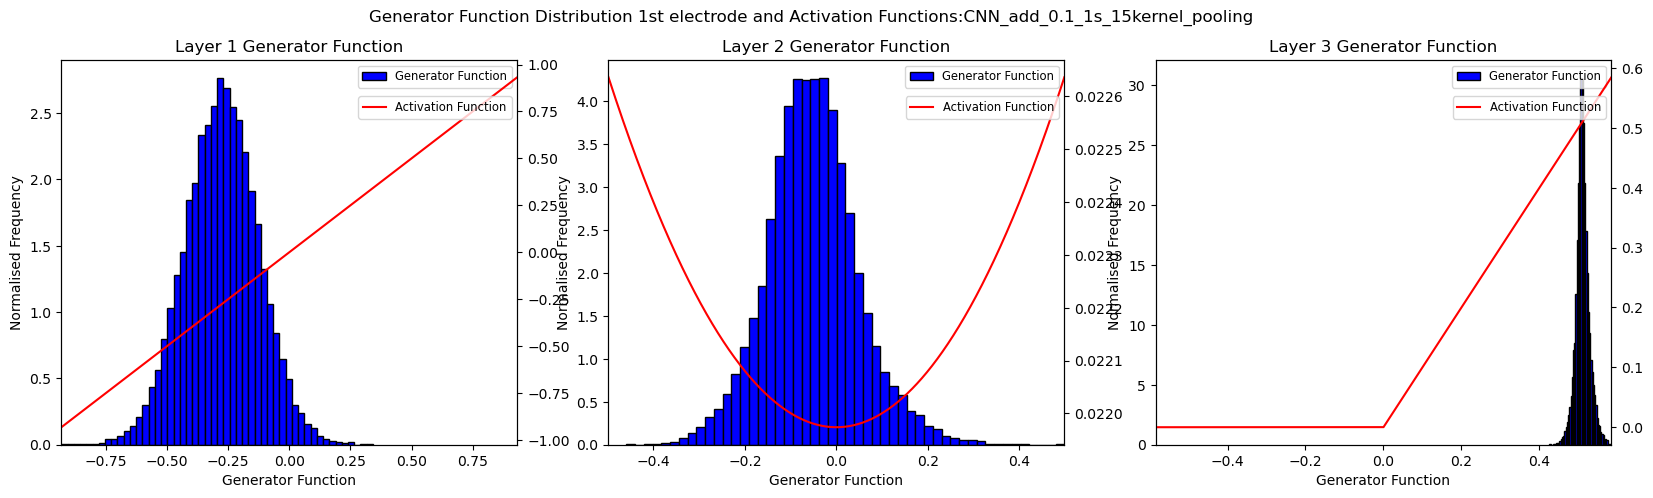

In [ ]:
activ_funcs = ["linear","ReLU","ReLU"]
if activ_func2 == "2sig":
    activ_funcs = ["linear","2sig","ReLU"]
else:
    activ_funcs = ["linear","ReLU","ReLU"]

show_generator(model_path,AutoEncoder, activ_funcs, magnitude, shift,model_title)